In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, json, math, psycopg2, csv
from sklearn import svm, preprocessing
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
import matplotlib.ticker as plticker
import re 
import os
import glob

In [4]:
"""Helper function to convert unix time to readable dates
Format e.g '1234567890'=> 2009-02-14 include %H:%M:%S' for time (08:31:30) and year (2009)
"""
def convertTimeUnix(timestamps):
    timestamp = datetime.fromtimestamp(timestamps)
    readableTime=(timestamp.strftime('%Y-%m-%d'))
    return(readableTime)

"""another helper function that will transform unix time key in a df to new readeable time"""
def keyChange(dfs):
    for column in dfs['resp_time']:
        columnSeries=dfs['resp_time']
    unixTime=(columnSeries.values)
    for times in unixTime:
        store=times
        rTime=convertTimeUnix(times)
        dfs['resp_time'].replace(
        to_replace=[store],
        value=rTime,
        inplace=True)

"""helper function that removes NaN from array"""
def filt(df,key):   
    filteredDf = df[df[key].notnull()]
    return filteredDf

"""helper function that revises the deadlines csv file to 
format it the same was as the other dfs"""
def explode(df):
    df['resp_time']=np.nan
    for date in df:
        df['resp_time'].fillna(df[date],inplace=True)
    return df
    
"""important function, normalize each data into the range 0 to 1 to fit into a scatter plot
"""
def normalize(df,key):
    array=df[key].values
    X=array.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_X=scaler.fit_transform(X)
    return normalized_X

In [5]:
"""input the directory path of a folder with the files, include / at the end
these functions takes keys we want and creates new database with readable times
"""

def sleep(directoryPath):
    #directoryPath=input("What is the path to the directory to the sleep files? ")
    dataSleep=[]
    for file_name in [file for file in os.listdir(directoryPath) if file.endswith('.json')]:
      with open(directoryPath + file_name) as json_file:
        data=json.load(json_file)
        dataSleep.append(data)
    """Extracting resp_time and hour from data"""
    keys=["resp_time","hour"]
    simplified=[]
    for user in dataSleep:
        for dic in user:
            hourAndDate=({k:v for k, v in dic.items() if k in keys})
            simplified.append(hourAndDate) 
    df=pd.DataFrame(simplified)
    """covert unix time to readable time using helper functions above"""
    keyChange(df)
    filtered=filt(df,"hour")
    norm=normalize(filtered,"hour")
    modDf = filtered.assign(normalizedHour = norm)
    return modDf


def stressLevels(directoryPath2):
    #directoryPath2=input("What is the path to the directory stress files? ")
    dataStress=[]
    for file_name in [file for file in os.listdir(directoryPath2) if file.endswith('.json')]:
      with open(directoryPath2 + file_name) as json_file:
        data=json.load(json_file)
        dataStress.append(data)
    keys = ('level','resp_time')
    simplified2=[]
    for user in dataStress:
        for dic in user:
            levelAndDate=({k:v for k, v in dic.items() if k in keys})
            simplified2.append(levelAndDate)
    df2=pd.DataFrame(simplified2)
    keyChange(df2)
    filtered2=filt(df2,"level")
    norm2=normalize(filtered2,"level")
    modDf2 = filtered2.assign(normalizedLevel = norm2)
    return modDf2
    
def deadlines(deadlinesCvsfile):
    #deadlinesCvsfile=input("What is the deadlines file? ")
    dedf=pd.read_csv(deadlinesCvsfile)
    del dedf['uid']
    structure=[]
    for (columnName, columnData) in dedf.iteritems():
        for val in columnData:
            store=({columnName:val})
            structure.append(store)
    resp_time=[]
    deadlines=[]
    for dic in structure:
        for key in dic.keys():
            resp_time.append(key)
        for values in dic.values():
            deadlines.append(values)
    df3 = pd.DataFrame(list(zip(resp_time, deadlines)), 
               columns =['resp_time', 'deadlines']) 
    filtered3=filt(df3,"deadlines")
    norm3=normalize(filtered3,"deadlines")
    modDf3 = filtered3.assign(normalizedDeadlines = norm3)
    return modDf3

What is the directory to the sleep data? /Users/sungyeon/training/sleep/
What is the directory to the stress level data? /Users/sungyeon/training/stress/
What is csv file for the deadlines data called deadlines.csv


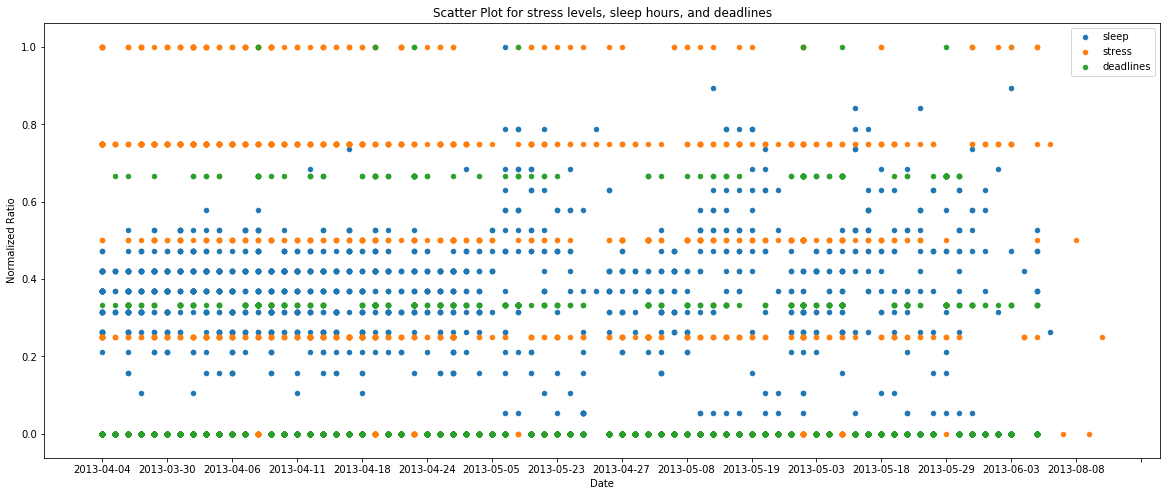

In [6]:
"""creating scatter plots"""

def scatter():
    sle=input("What is the directory to the sleep data? ")
    stre=input("What is the directory to the stress level data? ")
    dea=input("What is csv file for the deadlines data called ")
    sleepdf=sleep(sle)
    stressdf=stressLevels(stre)
    deadlinesdf=deadlines(dea)
    ax = sleepdf.plot.scatter(x='resp_time',
                      y='normalizedHour',label="sleep",
                      c='tab:blue')
    ax2 = stressdf.plot.scatter(x='resp_time',
                      y='normalizedLevel',label="stress",
                      c='tab:orange',ax=ax)
    ax3 = deadlinesdf.plot.scatter(x='resp_time',
                      y='normalizedDeadlines',label="deadlines",
                      c='tab:green',ax=ax2,figsize=(20, 8))
    loc = plticker.MultipleLocator(base=5.0) 
    ax.xaxis.set_major_locator(loc)
    plt.title("Scatter Plot for stress levels, sleep hours, and deadlines")
    plt.ylabel('Normalized Ratio')
    plt.xlabel("Date")
    

sleepdf=sleep("/Users/sungyeon/training/sleep/")
stressdf=stressLevels("/Users/sungyeon/training/stress/")
deadlinesdf=deadlines("deadlines.csv")
scatter()


In [8]:
"""for training data, used the train_test_split imported from sklearn
this function shufffles the dataset, train_split is 75% of the data and 
the test_split will be the remainding 25%"""
    
def split(data,data2,key,key2):
    X_train, X_test,y_train,y_test=train_test_split(
        data[key],data2[key2],random_state=0)
    print("X_train shape:{}".format(X_train.shape))
    print("y_train shape:{}".format(y_train.shape))
    print("---------------------------------------")
    print("X_test shape:{}".format(X_test.shape))
    print("y_test shape:{}".format(y_test.shape))
    #knn=KNeighborsClassifier(n_neighbors=1)
    #knn.fit(X_train,y_train)
    #KNeighborsClassifier(algorithm="auto",leaf_size=30,metric="minkowski",
                     #metric_params=None, n_jobs=1,n_neighbors=1,p=2,weights="uniform")
    #return X_train, X_test, y_train, y_test


    
sleepdf=sleep("/Users/sungyeon/training/sleep/")
stressdf=stressLevels("/Users/sungyeon/training/stress/")
deadlinesdf=deadlines("deadlines.csv")

X_train shape:(1042,)
y_train shape:(1042,)
---------------------------------------
X_test shape:(348,)
y_test shape:(348,)


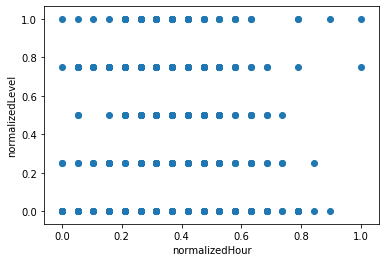

In [9]:
"""the length of the datasets for sleep hours and stress levels are not consistent 
so this function takes the minimum
"""


sleepdf=sleep("/Users/sungyeon/training/sleep/")
stressdf=stressLevels("/Users/sungyeon/training/stress/")
deadlinesdf=deadlines("deadlines.csv")


"""this formatting function will find the minimum range then create a new df 
so both databases have consistent lengths and also uses split function
"""

def formatting(data,data2,key,key2):
    if len(data)==len(data2):
        pass
    else:
        minimum=min(len(data),len(data2))
        if len(data)>len(data2):
            new=data[key][:minimum] 
            data=pd.DataFrame(new, columns = [key]) 
        if len(data2)>len(data):  
            new=data2[key2][:minimum] 
            data2 = pd.DataFrame(new, columns = [key2])
        plt.scatter(data[key],data2[key2])
        plt.ylabel(key2)
        plt.xlabel(key)
        return split(data,data2,key,key2)

                        
formatting(sleepdf,stressdf,"normalizedHour","normalizedLevel")

In [10]:
def knnFit(data,data2,key,key2):
    knn=KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)
    KNeighborsClassifier(algorithm="auto",leaf_size=30,metric="minkowski",
                     metric_params=None, n_jobs=1,n_neighbors=1,p=2,weights="uniform")


#----------Testing Codes-------------
#sleep() #input'/Users/sungyeon/training/sleep/'
#stressLevels()#input"/Users/sungyeon/training/stress/"
#deadlines()#input"deadlines.csv"


#"""for combine() function"""
#/Users/sungyeon/training/sleep/
#/Users/sungyeon/training/stress/
#deadlines.csv

#normalize(sleep('/Users/sungyeon/training/sleep/'),"hour")
#print("------------------------------")
#normalize(stressLevels("/Users/sungyeon/training/stress/"),"level")
#print("------------------------------")
#normalize(deadlines("deadlines.csv"),"deadlines")

In [ ]:
if __name__ == '__main__':
    pass